# Generalised Linear Model for bionomial distribution

This model in prototyped with TensorFlow Probability and inferecne is performed with variational Bayes by stochastic gradient descent. 

Author: Yuanhua Huang

Date: 16/12/2019

### The model

$$y_i = X_i \times w$$
$$P(a_i|d_i, y_i) = y_i^{(a_i)}(1-y_i)^{(d_i-a_i)}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

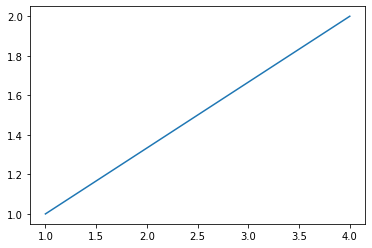

In [2]:
fig = plt.figure()
plt.plot([1,4], [1,2])
plt.show()

In [3]:
class BinomRegression():
    """
    d: number of theta categories
    K: number of components
    """
    def __init__(self, d, K, name=None):
        self.w_size = tf.Variable(tf.random.uniform([K], 0.3), name='w_size')
        self.beta_size = tf.Variable(tf.random.uniform([d, 2], 0.3), name='beta_size')
    
    @property
    def weight(self):
        """Variational posterior for the weight"""
        return tfd.Dirichlet(tf.math.exp(self.w_size))

    @property
    def ASR(self):
        """Variational posterior for the binomial rate"""
        return tfd.Beta(tf.math.exp(self.beta_size[:,0]), 
                        tf.math.exp(self.beta_size[:,1]))
    
    @property
    def losses(self):
        """Sum of KL divergences between posteriors and priors"""
        w_prior = tfd.Dirichlet(tf.ones([K]))
        theta_prior = tfd.Beta([0.1, 3, 9.9], [9.9, 3, 0.1])
        
        return (tf.reduce_sum(tfd.kl_divergence(self.weight, w_prior)) +
                tf.reduce_sum(tfd.kl_divergence(self.ASR, theta_prior)))
    
    def logLik(self, A, D, GT, sampling=False):
        """binomial coefficient needs to be added"""
        sample = lambda x: x.sample() if sampling else x.mean()
        _theta = tf.tensordot(tf.tensordot(GT, sample(self.ASR), axes=[[2], [0]]),
                              sample(self.weight), axes=[[1], [0]])
        
        _logLik = A * tf.math.log(_theta) + (D - A) * tf.math.log(1 - _theta)
        return _logLik
    
    def fit(self, A, D, GT, num_steps=100, optimizer=None,
            learn_rate=0.05):
        """Fit the model's parameters"""
        if optimizer is None:
            optimizer = tf.optimizers.Adam(learning_rate=learn_rate)
            
        loss_fn = lambda: (self.losses - tf.reduce_sum(self.logLik(A, D, GT)))
        
        losses = tfp.math.minimize(loss_fn, 
                                   num_steps=num_steps, 
                                   optimizer=optimizer)
        return losses

### Simulation

In [4]:
import numpy as np

# Settings
np.random.seed(2)

K = 4   #number of dimensions
N = 200 #number of datapoints to generate

# Generate data
w_true = np.random.dirichlet([1]*K)
GT = np.random.multinomial(1, [1/3, 1/3, 1/3], size=(N, K))
theta_true = np.dot(GT, [0.01, 0.5, 0.99])
theta_mean = np.dot(theta_true, w_true)
D = np.random.randint(2, 25, size=(N, 1))
A = np.random.binomial(D, theta_mean)

In [5]:
A = tf.convert_to_tensor(A, dtype=tf.float32)
D = tf.convert_to_tensor(D, dtype=tf.float32)
GT = tf.convert_to_tensor(GT, dtype=tf.float32)

In [6]:
w_true

array([0.29096973, 0.0133462 , 0.4053198 , 0.29036427])

In [7]:
model = BinomRegression(3, K)

In [8]:
model.w_size

<tf.Variable 'w_size:0' shape=(4,) dtype=float32, numpy=array([0.81620485, 0.41840777, 0.5186783 , 0.6159264 ], dtype=float32)>

In [ ]:
tf.tensordot(tf.tensordot(GT, model.ASR.mean(), axes=[[2], [0]]),
             model.weight.mean(), axes=[[1], [0]]).shape

In [ ]:
losses = model.fit(A, D, GT, num_steps=500)

In [10]:
losses.shape

TensorShape([500])

In [ ]:
fig = plt.figure()
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Interations")
plt.show()

In [12]:
tf.exp(model.beta_size)

<tf.Tensor: id=3783, shape=(3, 2), dtype=float32, numpy=
array([[ 0.17300138, 16.120369  ],
       [ 1.851408  ,  1.8353181 ],
       [16.90907   ,  0.19729044]], dtype=float32)>

In [13]:
model.weight.mean()

<tf.Tensor: id=3790, shape=(4,), dtype=float32, numpy=array([0.29306486, 0.01050822, 0.4054677 , 0.29095918], dtype=float32)>

In [15]:
losses

<tf.Tensor: id=3780, shape=(500,), dtype=float32, numpy=
array([406378.94, 400950.16, 395899.38, 391505.9 , 387664.3 , 384210.62,
       380984.38, 377855.75, 374741.  , 371587.78, 368383.5 , 365148.9 ,
       361915.44, 358710.3 , 355554.88, 352473.75, 349498.25, 346659.12,
       343976.1 , 341453.6 , 339085.6 , 336865.3 , 334789.8 , 332857.56,
       331065.84, 329411.38, 327893.  , 326512.3 , 325269.56, 324160.47,
       323177.75, 322315.12, 321567.62, 320928.4 , 320384.56, 319918.53,
       319512.6 , 319149.97, 318815.7 , 318497.3 , 318188.62, 317891.22,
       317610.97, 317354.22, 317125.5 , 316927.6 , 316759.62, 316617.06,
       316492.75, 316380.6 , 316276.78, 316179.16, 316085.75, 315995.97,
       315910.12, 315828.72, 315751.94, 315680.38, 315615.22, 315556.88,
       315504.75, 315457.84, 315415.12, 315375.28, 315336.94, 315299.56,
       315263.12, 315227.62, 315193.38, 315160.72, 315130.22, 315102.25,
       315076.56, 315053.16, 315031.47, 315010.7 , 314990.38, 31497